In [21]:
import os
import numpy as np
import time
import tensorflow as tf
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
assert tf.__version__.startswith('2')
from tensorflow.keras.preprocessing import image_dataset_from_directory

#load images as data and split dataset for training and validation
train_dir = "syringe/train"
validation_dir = "syringe/validation"
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 154 files belonging to 2 classes.
Found 61 files belonging to 2 classes.


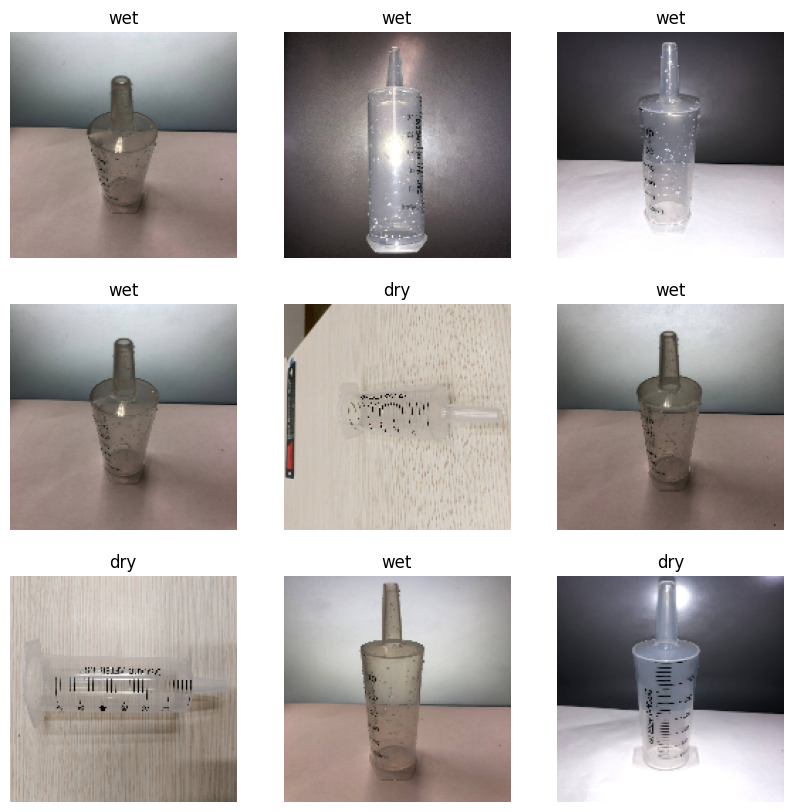

In [2]:
#creates a plot of the first 9 images with labels in the training dataset
syringes = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(syringes[labels[i]])
    plt.axis("off")
  plt.show()

In [3]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('No. of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('No. of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

No. of validation batches: 2
No. of test batches: 0


In [4]:
#configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

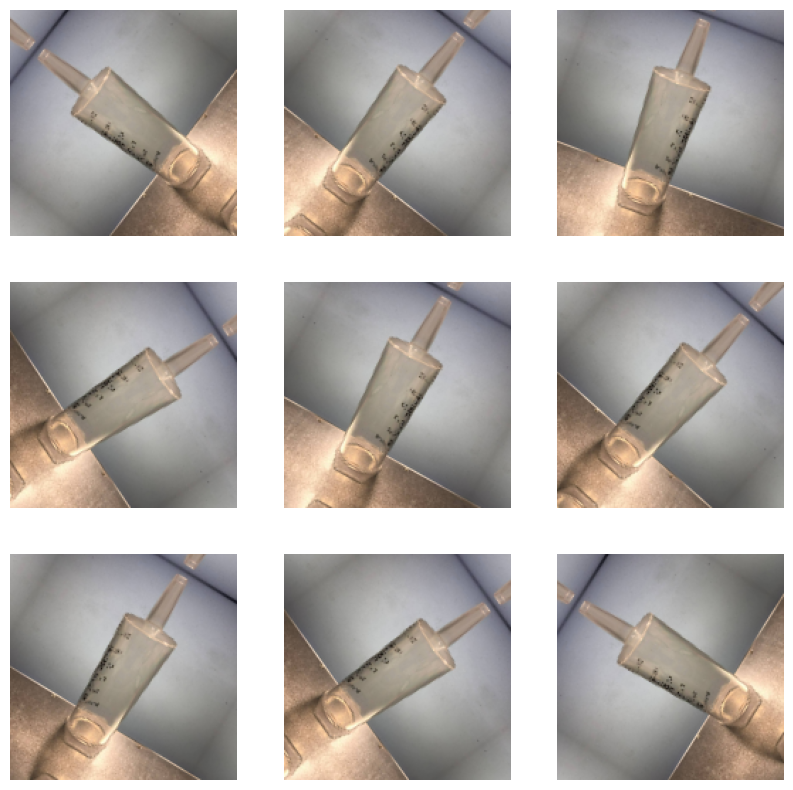

In [5]:
#data augmentation to reduce overfitting by applying transformations to training images
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
  plt.show()

#rescale pixel values of the model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

#create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [6]:
#converts each image from the batch of  into a block features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

#freeze convolutional base
base_model.trainable = False

base_model.summary()

(32, 5, 5, 1280)
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________

In [7]:
# add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [8]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [9]:
#building model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
#compile the model before training it
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
#1.2 trainable parameters are divided between two objects, weights and biases
len(model.trainable_variables)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

C:\Users\sharo\anaconda3\envs\CSC3005_Data_Analytics\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


2

In [11]:
#Train the model for 200 epochs 
initial_epochs = 200  
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2/2 [==============================] - 2s 238ms/step - loss: 0.6883 - accuracy: 0.6393
initial loss: 0.69
initial accuracy: 0.64


In [12]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/200
5/5 [==============================] - 6s 540ms/step - loss: 0.6354 - accuracy: 0.6234 - val_loss: 0.6969 - val_accuracy: 0.6393
Epoch 2/200
5/5 [==============================] - 3s 500ms/step - loss: 0.6492 - accuracy: 0.5844 - val_loss: 0.6976 - val_accuracy: 0.6230
Epoch 3/200
5/5 [==============================] - 3s 520ms/step - loss: 0.5713 - accuracy: 0.6753 - val_loss: 0.6938 - val_accuracy: 0.6230
Epoch 4/200
5/5 [==============================] - 3s 509ms/step - loss: 0.6096 - accuracy: 0.6299 - val_loss: 0.6910 - val_accuracy: 0.6230
Epoch 5/200
5/5 [==============================] - 4s 527ms/step - loss: 0.6103 - accuracy: 0.6429 - val_loss: 0.6900 - val_accuracy: 0.6230
Epoch 6/200
5/5 [==============================] - 4s 526ms/step - loss: 0.5981 - accuracy: 0.6494 - val_loss: 0.6884 - val_accuracy: 0.6393
Epoch 7/200
5/5 [==============================] - 4s 536ms/step - loss: 0.6492 - accuracy: 0.5974 - val_loss: 0.6849 - val_accuracy: 0.6393
Epoch 8/200
5

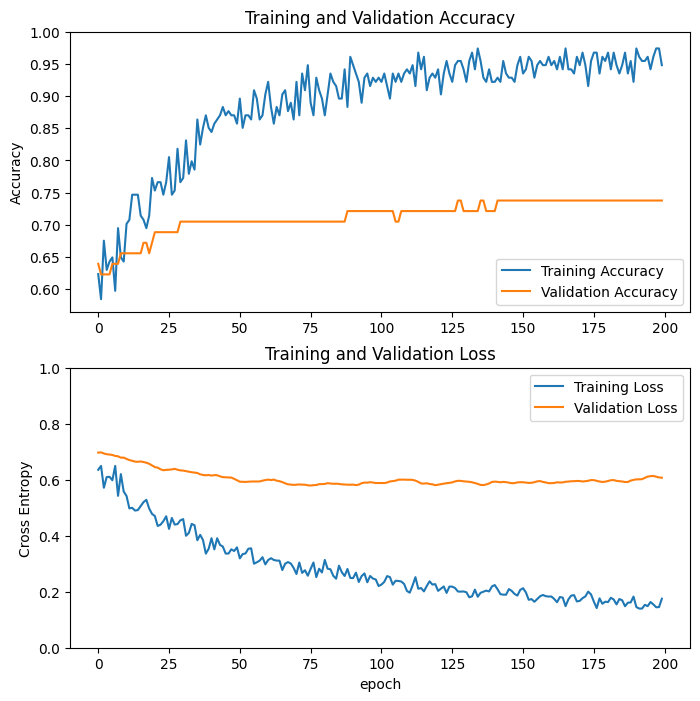

In [13]:
#learning curves of the training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
##fine-tuning the weights of the top layer of model as they were not updated during training
#unfreeze the base model and set bottom layer to be untrainable
base_model.trainable = True

In [15]:
print("Number of layers in the base model: ", len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100

#freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

  #compile the model by using a lower learning rate to readapt the pretrained weights
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

Number of layers in the base model:  154


In [16]:
model.summary()
len(model.trainable_variables)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

56

In [17]:
#continue training the model
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 200/210
5/5 [==============================] - 9s 848ms/step - loss: 0.1801 - accuracy: 0.9351 - val_loss: 0.7536 - val_accuracy: 0.7377
Epoch 201/210
5/5 [==============================] - 5s 733ms/step - loss: 0.1043 - accuracy: 0.9740 - val_loss: 0.6821 - val_accuracy: 0.7541
Epoch 202/210
5/5 [==============================] - 5s 741ms/step - loss: 0.0945 - accuracy: 0.9805 - val_loss: 0.6380 - val_accuracy: 0.7869
Epoch 203/210
5/5 [==============================] - 5s 690ms/step - loss: 0.0656 - accuracy: 0.9935 - val_loss: 0.5993 - val_accuracy: 0.7377
Epoch 204/210
5/5 [==============================] - 5s 735ms/step - loss: 0.0819 - accuracy: 0.9740 - val_loss: 0.7622 - val_accuracy: 0.7541
Epoch 205/210
5/5 [==============================] - 5s 797ms/step - loss: 0.0976 - accuracy: 0.9740 - val_loss: 0.7041 - val_accuracy: 0.7869
Epoch 206/210
5/5 [==============================] - 5s 840ms/step - loss: 0.0611 - accuracy: 0.9935 - val_loss: 0.8552 - val_accuracy: 0.7377

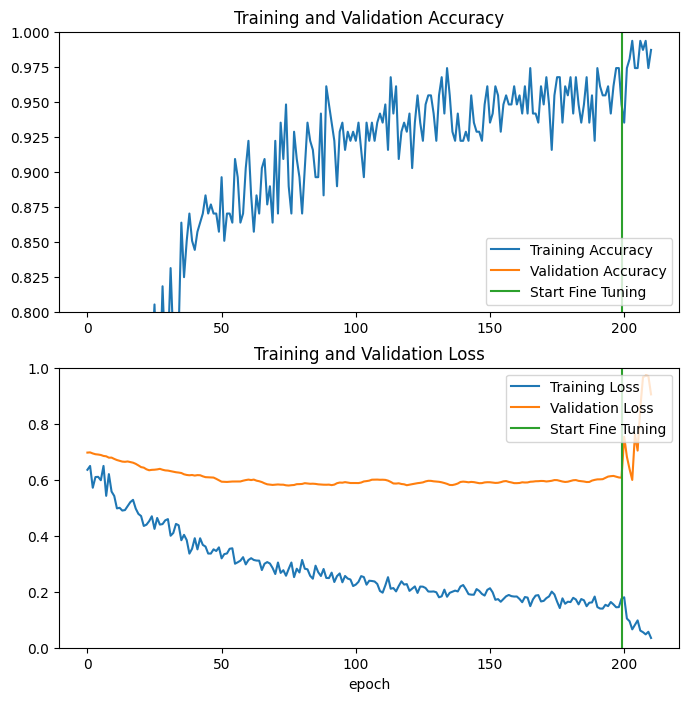

In [18]:
#after fine tuning, the model accuracy have improved on the validation set
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

C:\Users\sharo\anaconda3\envs\CSC3005_Data_Analytics\lib\site-packages\keras\utils\generic_utils.py:915: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer

In [31]:
#Retrieve a batch of images from the test set and check the predictions
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
#plot model predictions
plt.figure(figsize=(8, 8))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(syringes[predictions[i]])
  plt.axis("off")
plt.show

StopIteration: 

In [22]:
#export it as saved model to be loaded to pi
t = time.time()
export_path = "tmp/saved_models/{}".format(int(t))
model.save(export_path)
export_path

INFO:tensorflow:Assets written to: tmp/saved_models/1630095084\assets


C:\Users\sharo\anaconda3\envs\CSC3005_Data_Analytics\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


'tmp/saved_models/1630095084'

In [23]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch).max()

0.0

In [30]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = syringes[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

TypeError: only integer scalar arrays can be converted to a scalar index

In [32]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 'reloaded_predicted_label_batch' is not defined